# Энергия ферромагнетика (2D)
### Условие задачи

**Дано:**
- двумерная решетка молекул, расположенных в узлах кристаллической решетки, размеров $L_x \times L_y$ с периодическими границами
- каждая молекула обладает спином +1 или -1
- межмолекулярное взаимодействие описывается константами $J_{ij} = 1$
- модель Изинга


**Требуется:**
- согласно модели Изинга рассчитать среднюю энергию $\langle E \rangle$ для указанной цепочки молекул при:
    - размерах решетки $L_x \in [2, 3, ..., 8]$, $L_y = 4$
    - температурах $kT \in [1, 1.1, ..., 5.0]$
- сохранить массив средних энергий при помощи `np.save`
- вывести время расчета каждой итерации по $Lx$ или по $k T$
- отобразить цветовую карту:
    - ось абсцисс - $L_x$,
    - ось ординат - $k T$,
    - цветом отобразить нормированное значение средней энергии $\frac{\langle E \rangle}{Lx Ly}$,
    - подписать оси,
    - отобразить цветовую шкалу (`colorbar`),
    - засечки должны соответствовать значениям $Lx, kT$.
- к каждой функции добавить `docstring` с описанием того, что функция делает, всех параметров и возвращаемого значения    

**Описание:**

**Одномерный случай**

Модель Изинга является моделью магнетика. Пусть этот магнетик состоит из молекул, расположенных в узлах регулярной решетки. Пусть всего таких узлов будет $N$ штук, с индексами $i=1,\ldots, N$.

Предположим, что каждая молекула может быть представлена в виде магнитной стрелки, которая всегда либо направлена вдоль некоторой заданной оси, либо в противоположном направлении. То есть каждая молекула $i$ имеет две конфигурации, которые можно описывать с помощью "спиновой" переменной $\sigma_i$. Эта переменная принимает значение $+1$ (параллельно оси, спин направлен вверх) и $-1$ (антипараллельно оси, спин направлен вниз).

Пусть $\sigma = \{\sigma_1, \sigma_2, \ldots, \sigma_N\}$ обозначает набор значений всех $N$ спинов. Имеется $2^N$ различных наборов $\sigma$, и каждый из них описывает некоторое состояние системы. 

Гамильтониан системы  состоит из двух частей: первая $E_0$ включает вклад межмолекулярных сил внутри магнетика, а вторая $E_1(\sigma)$ вклад от взаимодействий каждого спина с внешним магнитным полем (здесь считается нулевым). 
$$H(\sigma)=E_0(\sigma)+E_1(\sigma)$$

В любой физической системе мы предполагаем все взаимодействия инвариантными по отношению к обращению времени, что означает инвариантность $E$ при изменении знаков всех полей и намагниченностей. Энергия должна быть четной функцией от $\sigma$:
$$E_0(\sigma_1,\ldots, \sigma_N)=E_0(-\sigma_1,\ldots, -\sigma_N)$$

Энергия системы при нулевом внешнем магнитном поле равна сумме произведений **соседних** спинов на константы взаимодействия $J_{ij}$
$$E(\sigma) = -\sum_{i} J_{i,i+1}\sigma_{i}\sigma_{i+1} $$

Вероятность находиться в состоянии $\sigma$
$$P(\sigma)=\frac{e^{-\beta E(\sigma)}}{Z},$$
	где $Z = \sum_{\sigma} e^{-\beta E(\sigma)}-$ статистическая сумма, $\beta = \frac{1}{k T}-$ обратная температура, $k-$ константа Больцмана.
	
Средняя энергия системы 
$$\langle E \rangle = \frac{1}{Z}\sum_{\{\sigma \}} E(\sigma)e^{-\frac{E(\sigma)}{kT}}$$
рассчитывается по всевозможным состояниям системы, т.е. всевозможным наборам $\sigma$.

**Двумерный случай**

В случае двумерной решетки энергия системы при нулевом внешнем магнитном поле вычисляется следующим образом: 
$$E(\sigma) = -\sum_{i,j} J_{ij}(\sigma_{i,j}\sigma_{i+1,j} + \sigma_{i,j}\sigma_{i,j+1})$$

**Правила оценивания:**

- оценка за корректно выполненный расчет для количества молекул в цепочке $L_x$, баллов из 100:
```
    Lx    =   2,   3,   4,   5,    6,    7,     8
    g(Lx) = 1.0, 1.8, 3.3, 6.4, 12.6, 24.9,  50.0
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выведены значения средней энергии - 20
    - не построена карта - 20
    - отсутствует `docstring` - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{Lx=2}^{8}{g(Lx)} - \sum_{i}{p(i)}$

**Всё задание вкратце...**

<center>
    <img src='https://drive.google.com/uc?id=1zZY58yI0XZ4zm-phbhlq6kX7fIcGBhNN' width="500"/>
</center>

In [97]:
#!c1.32
import numpy as np 
import numba
from numba import jit, njit, cuda
from tqdm.notebook import trange
from tqdm import tqdm
from time import time 

In [98]:
#!c1.32
L_x = [2, 3, 4, 5, 6, 7, 8]
L_y = 4
kT = np.arange(start=1.0, stop=5.1, step=0.1)

**Важное пояснение**: опытным путем было замечено, что, если выполнять всё в одной функции, то это дает ускорение применерно раз в 7. Далее есть версия решения и в одну функцию (с помощью которой и считалось всё в итоге), и разбитое на несколько функций по смысловым блокам


In [91]:
#!c1.32
@njit(parallel=True, fastmath=True)
def IsingEnergy(L_x, L_y, kT):
    '''
    Функция, которая симулирует модель Изинга для заданной решетки молекул 
    размера (L_x * L_y) и некоторого значения температуры kT
    ------------------------------------------------------------------------------

    Аргументы:
        L_x: размер решетки молекул по x
        L_y: размер решетки молекул по y
        kT: параметр температуры 
    ------------------------------------------------------------------------------

    Возвращаемое значение: средняя энергия системы с заданными параметрами
    '''
    
    Z = 0.0
    mean_energy = 0.0
    
    for i_ in numba.prange(2**(L_x * L_y)):
        i = numba.int64(i_)
        spin = np.empty(L_x * L_y, dtype=np.int8)
        for cell in range(L_x * L_y):
            if i & 1 == 0: 
                spin[cell] = -1
            else:
                spin[cell] = 1
            i = i >> 1
        spin = spin.reshape(L_x, L_y)
    
        energy = 0
        for i in range(L_x):
            for j in range(L_y):
                energy += (-1) * spin[i, j] * (spin[(i + 1) % L_x, j] + spin[i, (j + 1) % L_y])
    
        Z += np.e ** ((-1) * energy / kT)
        mean_energy += energy * np.e ** ((-1) * energy / kT)
    return (mean_energy / Z) * (1 / (L_x * L_y))

In [92]:
#!c1.32
def SystemCalculations(L_X, L_Y, kT):
    '''
    Функция, которая производит общет моделей Изинга для всех возможных
    параметров L_x и kT, замеряя время и сохраняя результаты в файл
    ------------------------------------------------------------------------------

    Аргументы:
        L_X: массив всех возможных размеров решетки молекул по x
        L_y: размер решетки молекул по y
        kT: массив всех возможных параметров температуры 
    ------------------------------------------------------------------------------

    Возвращаемое значение: None
    '''
    all_mean_energy = []
    for l_x in tqdm(L_X): 
        time_kT = []   
        t_lx = time()
        mean_energy_list = []
        for kt in kT:
            t_kt = time()
            mean_energy_list.append(IsingEnergy(l_x, L_y, kt))
            time_kT.append(time() - t_kt)
        
        print(f"Время для Lx = {l_x}: {time() - t_lx}")
        print(f"Average time over kT: {np.average(np.asarray(time_kT))}")
        print(f"Systems mean energy over kT: {mean_energy_list}\n")
        print("---------------------------------------------------------------")
        all_mean_energy.append(mean_energy_list)
        
        np.save('all_mean_energy', np.asarray(all_mean_energy))

In [93]:
#!c1.32
SystemCalculations(L_x, L_y, kT)

Время для Lx = 2: 3.023745536804199
Average time over kT: 0.07374689055652153
Systems mean energy over kT: [-1.9950947414062468, -1.9896786188808073, -1.9807487753449695, -1.9673111716909788, -1.9485144458851344, -1.9237582779717866, -1.8927729123774133, -1.8556563932181038, -1.81286316047101, -1.7651476160907025, -1.7134756254766457, -1.65892227079009, -1.6025740536214284, -1.5454491047728742, -1.4884422379376243, -1.4322953738038868, -1.3775895005233505, -1.3247522964105898, -1.2740753769508302, -1.2257360871954106, -1.1798201525284402, -1.1363428622913487, -1.095267561798701, -1.0565210070828932, -1.0200056246987825, -0.9856089838958376, -0.9532109011612631, -0.922688616156588, -0.8939204459706636, -0.866788269418056, -0.8411791316946008, -0.8169862012229521, -0.7941092592314017, -0.772454859865174, -0.7519362642279938, -0.7324732247580709, -0.713991675568291, -0.6964233686384532, -0.6797054839730113, -0.6637802331319113, -0.648594469174492]

----------------------------------------

100%|██████████| 7/7 [46:26<00:00, 398.10s/it]


In [99]:
#!c1.32
system_Energy = np.load('all_mean_energy.npy')
system_Energy

array([[-1.99509474, -1.98967862, -1.98074878, -1.96731117, -1.94851445,
        -1.92375828, -1.89277291, -1.85565639, -1.81286316, -1.76514762,
        -1.71347563, -1.65892227, -1.60257405, -1.5454491 , -1.48844224,
        -1.43229537, -1.3775895 , -1.3247523 , -1.27407538, -1.22573609,
        -1.17982015, -1.13634286, -1.09526756, -1.05652101, -1.02000562,
        -0.98560898, -0.9532109 , -0.92268862, -0.89392045, -0.86678827,
        -0.84117913, -0.8169862 , -0.79410926, -0.77245486, -0.75193626,
        -0.73247322, -0.71399168, -0.69642337, -0.67970548, -0.66378023,
        -0.64859447],
       [-1.99711779, -1.99383665, -1.98825271, -1.97949351, -1.96659182,
        -1.94853206, -1.92432618, -1.89312223, -1.85433583, -1.80777902,
        -1.75375117, -1.69305981, -1.62695673, -1.55700043, -1.48487836,
        -1.41223059, -1.34050963, -1.27089443, -1.20425882, -1.14118312,
        -1.08199278, -1.02680913, -0.97560137, -0.92823315, -0.88450084,
        -0.84416295, -0.80696

[Text(0.5, 33.0, 'Температура'),
 Text(114.0, 0.5, '$L_x$ размерность решетки'),
 Text(0.5, 1.0, 'Карта средних энергий системы молекул при заданных $L_x$ и kT')]

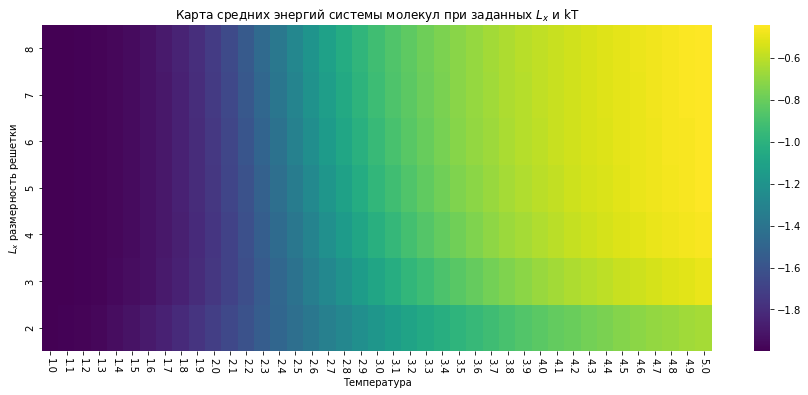

In [123]:
#!c1.32
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,6))

a = sns.heatmap(system_Energy, cmap="viridis")

a.set_yticklabels(L_x)
a.set_xticklabels(np.round(kT, 1), rotation=270)
a.invert_yaxis()
a.set(xlabel='Температура', ylabel='$L_x$ размерность решетки', title='Карта средних энергий системы молекул при заданных $L_x$ и kT')

Ну и обещанные функции

In [ ]:
#!c1.32
@njit(parallel=True, fastmath=True)
def Energy(spin, L_x, L_y, kT):
    '''
    Функция, которая считаем энергию системы при нулевом магнитном поле
    ------------------------------------------------------------------------------

    Аргументы:
        spin: двумерный массив спинов для системы молекул 
        L_x: размер решетки молекул по x
        L_y: размер решетки молекул по y
        kT: параметр температуры 
    ------------------------------------------------------------------------------

    Возвращаемое значение: 
        energy: энергия системы с заданной конфигурацией спинов 
    '''
    energy = 0
    for i in numba.prange(L_x):
        for j in range(L_y):
            energy += (-1) * spin[i, j] * (spin[(i + 1) % L_x, j] + spin[i, (j + 1) % L_y])
    return energy

In [ ]:
#!c1.32
@njit(parallel=True, fastmath=True)
def IsingEnergy(L_x, L_y, kT):
    '''
    Функция, которая рассчитывает среднюю энергию системы молекул на заданной
    решетке размерами (L_x * L_y) и параметре температуры kT
    ------------------------------------------------------------------------------

    Аргументы:
        L_x: размер решетки молекул по x
        L_y: размер решетки молекул по y
        kT: параметр температуры 
    ------------------------------------------------------------------------------

    Возвращаемое значение: нормированная средняя энергия системы с заданными 
    параметрами 
    '''
    
    Z = 0.0
    mean_energy = 0.0
    
    # массив для перебора всех конфигураций спинов
    for i_ in numba.prange(2**(L_x * L_y)):
        i = numba.int64(i_)
        spin = np.empty(L_x * L_y, dtype=np.int8)
        ## перебираем конфигурации спинов с помощью двоичного 
        ## представления чисел [1, 2^(L_x*L_y)]
        for cell in range(L_x * L_y):
            if i & 1 == 0: 
                spin[cell] = -1
            else:
                spin[cell] = 1
            i = i >> 1
        spin = spin.reshape(L_x, L_y)
        energy = Energy(spin, L_x, L_y, kT)
        # аккумулируем статсумму
        Z += np.e ** ((-1) * energy / kT)
        # аккумулируем среднюю энергию
        mean_energy += energy * np.e ** ((-1) * energy / kT)
    return (mean_energy / Z) * (1 / (L_x * L_y))